In [1]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [2]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [3]:
def extract_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Preserve original sampling rate
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram, sr  # Return both mel-spectrogram and sample rate

In [4]:
from tensorflow.keras import layers, models
#rcnn
def create_dcnn_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Convolutional layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Convolutional layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Flatten before LSTM layers
    model.add(layers.TimeDistributed(layers.Flatten()))
    
    # BiLSTM layer 1
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Dropout(0.2))
    
    # BiLSTM layer 2
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dropout(0.2))
    
    # Fully Connected Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [5]:
result_df=pd.read_csv('D://ASVspoof2021_DF_eval//filter_auds.csv')
audio_folder = 'D://ASVspoof2021_DF_eval//filtered_auds_augmented' 

In [6]:
import os
import numpy as np
import librosa
import librosa.display
import scipy.signal
import scipy.fftpack

# Spectral Subtraction for Denoising
def spectral_subtraction(y, sr, noise_frames=5):
    """Perform spectral subtraction for noise reduction."""
    # Compute STFT (Short-Time Fourier Transform)
    D = librosa.stft(y, n_fft=1024, hop_length=512)
    magnitude, phase = np.abs(D), np.angle(D)

    # Estimate noise power spectrum using the first few silent frames
    noise_spectrum = np.mean(magnitude[:, :noise_frames], axis=1, keepdims=True)

    # Subtract noise spectrum (ensure no negative values)
    magnitude_denoised = np.maximum(magnitude - noise_spectrum, 0)

    # Reconstruct signal using inverse STFT
    D_denoised = magnitude_denoised * np.exp(1j * phase)
    y_denoised = librosa.istft(D_denoised, hop_length=512)

    return y_denoised

# Mel Spectrogram Extraction
def extract_mel_spectrogram(file_path):
    """Extract Mel spectrogram after spectral subtraction."""
    y, sr = librosa.load(file_path, sr=None)  # Preserve original sampling rate
    y_denoised = spectral_subtraction(y, sr)  # Apply noise reduction

    mel_spectrogram = librosa.feature.melspectrogram(y=y_denoised, sr=sr, n_mels=128)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram, sr  # Return both mel-spectrogram and sample rate

# Directory containing noisy audio files
audio_folder = 'D://ASVspoof2021_DF_eval//filtered_auds_augmented'

# Prepare feature (X) and label (y) arrays
X, y = [], []

# Iterate over metadata to process audio files
for index, row in result_df.iterrows():
    file_name = row['File_Name']
    label = row['Label']
    file_path = os.path.join(audio_folder, file_name + '.flac')  # Assuming .flac files
    
    if os.path.exists(file_path):
        try:
            mel_spectrogram, sr = extract_mel_spectrogram(file_path)

            # Ensure consistent shape (128, 128)
            if mel_spectrogram.shape[1] > 128:
                mel_spectrogram = mel_spectrogram[:, :128]
            else:
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, 128 - mel_spectrogram.shape[1])), mode='constant')

            X.append(mel_spectrogram)
            y.append(label)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X to add a channel dimension (for deep learning models)
X = X.reshape(X.shape[0], 128, 128, 1)


C:\Users\Aaditya\AppData\Local\Temp\ipykernel_13644\2657359802.py:30: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)  # Preserve original sampling rate
c:\Users\Aaditya\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing DF_E_2407605: 
Error processing DF_E_2232706: 
Error processing DF_E_2455376: 
Error processing DF_E_2529863: 
Error processing DF_E_2410944: 
Error processing DF_E_2527516: 
Error processing DF_E_2457301: 
Error processing DF_E_2407873: 
Error processing DF_E_2574980: 


In [7]:
y.shape

(13122,)

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
model = create_dcnn_model((128, 128, 1))
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))




Epoch 1/10


288/288 [==============================] - 155s 495ms/step - loss: 0.6182 - accuracy: 0.6737 - val_loss: 0.7000 - val_accuracy: 0.6754
Epoch 2/10
288/288 [==============================] - 129s 448ms/step - loss: 0.4789 - accuracy: 0.8074 - val_loss: 0.4753 - val_accuracy: 0.8057
Epoch 3/10
288/288 [==============================] - 117s 407ms/step - loss: 0.4438 - accuracy: 0.8314 - val_loss: 0.4816 - val_accuracy: 0.8006
Epoch 4/10
288/288 [==============================] - 118s 409ms/step - loss: 0.4334 - accuracy: 0.8357 - val_loss: 0.4642 - val_accuracy: 0.8189
Epoch 5/10
288/288 [==============================] - 121s 419ms/step - loss: 0.4331 - accuracy: 0.8354 - val_loss: 0.4624 - val_accuracy: 0.8164
Epoch 6/10
288/288 [==============================] - 119s 415ms/step - loss: 0.4236 - accuracy: 0.8409 - val_loss: 0.4647 - val_accuracy: 0.8181
Epoch 7/10
288/288 [==============================] - 145s 503ms/step - loss: 0.4161 - accuracy: 0.8414 - val_loss: 0.4

In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

124/124 [==============================] - 12s 95ms/step - loss: 0.4464 - accuracy: 0.8235
Test accuracy: 0.8234696388244629


In [11]:
model.save('D:\ASVspoof2021_DF_eval\m1rcnn.h5')  # Replace with your desired path
print("Model saved successfully!")

c:\Users\Aaditya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully!


124/124 [==============================] - 12s 94ms/step - loss: 0.4464 - accuracy: 0.8235
Test accuracy: 0.8234696388244629
124/124 [==============================] - 11s 90ms/step
Confusion Matrix:
[[2468  124]
 [ 571  774]]


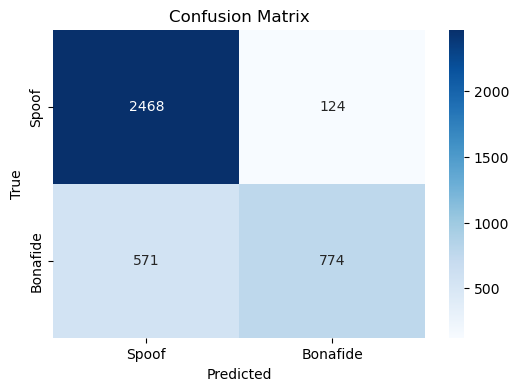

Classification Report:
              precision    recall  f1-score   support

       Spoof       0.81      0.95      0.88      2592
    Bonafide       0.86      0.58      0.69      1345

    accuracy                           0.82      3937
   macro avg       0.84      0.76      0.78      3937
weighted avg       0.83      0.82      0.81      3937

AUC: 0.8271604938271604
EER: 0.25462962962962965


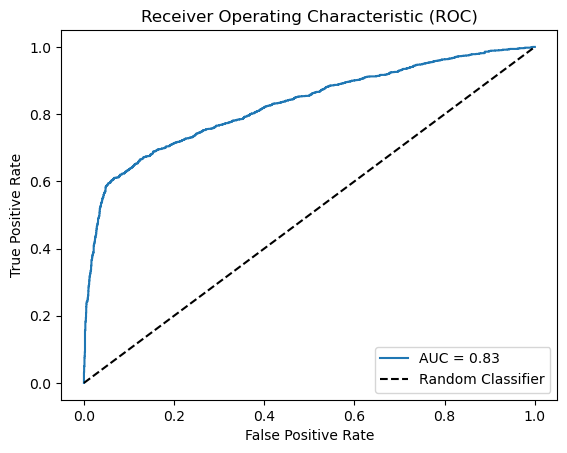

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Get predictions on the test set
y_pred_probs = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype("int32")  # Convert probabilities to binary labels

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix using a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Bonafide'], yticklabels=['Spoof', 'Bonafide'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report for Precision, Recall, F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Spoof', 'Bonafide']))

# Calculate AUC (Area Under Curve)
auc = roc_auc_score(y_test, y_pred_probs)
print(f'AUC: {auc}')

# Calculate EER (Equal Error Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
print(f'EER: {eer}')

# Plot ROC Curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
